# MODULE


In [10]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# SCIPTDATA

In [11]:


class ScriptData:

    def __init__(self) -> None:
        # Initialize class with empty map and API key
        self.map = dict()
        self.myKey = "Z8NVJC5M4WYK1JLH"

    def __getitem__(self, stk):
        # Return stock data from map
        return self.map[stk]

    def __setitem__(self, key, value):
        # Add or update stock data in map
        self.map[key] = value

    def __contains__(self, key):
        # Check if stock data is in map
        return key in self.map.keys()

    def fetchNconvert(self, stk):
        self.fetch_intraday_data(stk)
        self.convert_intraday_data(stk)
        return self[stk]

    def  fetch_intraday_data(self, stk):
        # Fetch intraday stock data and store in map
        ts = TimeSeries(key=self.myKey, output_format='csv')
        data, meta_data = ts.get_intraday_extended(stk, '60min', 'year1month1')
        self.map[stk] = data
        
    def convert_intraday_data(self, stk):
        data = pd.DataFrame(self[stk])
        data.columns = data.iloc[0]
        data = data.drop(data.index[0])
        data = data[::-1]
        data.index = data.index[::-1]
        data[['open', 'high', 'low', 'close']] = data[['open', 'high', 'low', 'close']].astype(float)
        data['volume'] = data['volume'].astype(int)
        self[stk] = data
        return data
        

# INDICATOR

In [12]:
def indicator1(  df, timeperiod=5  ):

    # set NaN    
    lst = [np.nan]*(timeperiod-1)
    # Mean and create DataFrame
    lst.extend([df['close'][i-timeperiod:i].mean() for i in range(timeperiod,df['close'].size+1)])
    indiframe = pd.DataFrame()
    indiframe['time'], indiframe['indicator'] = df['time'], lst
    
    return indiframe

# STRATEGY

In [13]:
class Strategy:

    def __init__(self, stk) -> None:
        # fetchNconvert

        stock = ScriptData()
        df = stock.fetchNconvert(stk)
        self.close_data = df['close']
        self.indicator_data = indicator1(df, timeperiod=5)

    def get_script_data(self):
        return self.close_data, self.indicator_data

    def get_signal(self):

        self.signal = pd.DataFrame()
        indi_data = self.indicator_data
        cls_data = self.close_data

        temp = 0

        for i in range(0, cls_data.size):
            action = 0 if cls_data.iloc[i] > indi_data.iloc[i]['indicator'] else 1

            if action != temp:
                temp = action
                _amt = cls_data.iloc[i]
                _time = indi_data.iloc[i]['time']
                new_data = pd.DataFrame(
                    {'amt': _amt, 'time': _time, 'Action': ["buy" if action else "sell"]})

                self.signal = pd.concat(
                    [self.signal, new_data], ignore_index=True)

        print(self.signal)

        # PLOTTING

    def plot(self):

        plt.figure(figsize=(80, 10))
        plt.xticks(rotation=90)
        plt.grid()

        self.close_data.index -= 1
        print("_"*150, " \nGreen : Purchase \n Red : Sell")

        plt.plot(self.close_data)
        plt.plot(self.indicator_data.time, self.indicator_data.indicator)

        color = ['red' if i == 'sell' else 'green' for i in self.signal['Action']]
        plt.scatter(self.signal.time, self.signal.amt,c=color, marker='h', s=50)


# TESTING

In [ ]:
Strateg = Strategy('NVDA') #CHANGE STOCK-NAME TO TRY ON DIFFERENT DATA-SET

# Currently i am using "get_intraday_extended(stk, '60min', 'year1month1')" for past 1 month of data.

       amt                 time Action
0   195.00  2023-02-01 05:00:00    buy
1   200.21  2023-02-01 10:00:00   sell
2   209.39  2023-02-02 05:00:00    buy
3   209.74  2023-02-02 09:00:00   sell
4   213.22  2023-02-02 15:00:00    buy
..     ...                  ...    ...
84  227.06  2023-03-01 18:00:00    buy
85  227.31  2023-03-01 19:00:00   sell
86  224.21  2023-03-02 05:00:00    buy
87  227.02  2023-03-02 10:00:00   sell
88  232.09  2023-03-02 18:00:00    buy

[89 rows x 3 columns]
______________________________________________________________________________________________________________________________________________________  
Green : Purchase 
 Red : Sell


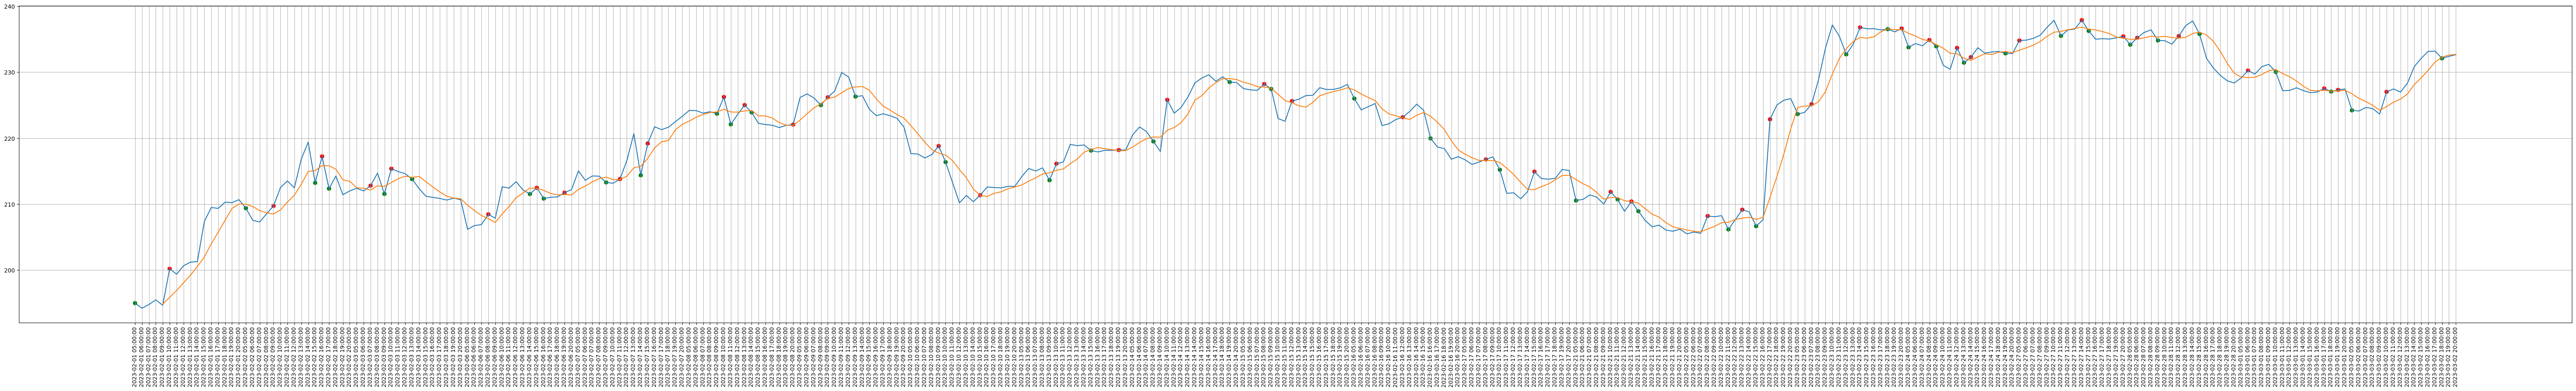

In [15]:
Strateg.get_signal()
Strateg.plot()
